In [1]:
import numpy as np
from keras.applications.vgg16 import VGG16, preprocess_input
from keras.preprocessing.image import load_img, img_to_array
from keras.models import Sequential, Model
from keras.layers import MaxPool2D, AvgPool2D, Conv2D
import keras.backend as K

Using TensorFlow backend.


In [2]:
def preprocess_image(img_path, height=None, width=None):
    if width is None and height is None:
        target_size = None
    else:
        if width is None and height is not None:
            w, h = load_img(path=img_path).size
            width = int(w * height/h)
        elif width is not None and height is None:
            w, h = load_img(path=img_path).size
            height = int(h * width/w)
        
        target_size = (height, width)
        
    img = load_img(path=img_path, target_size=target_size)
    img = img_to_array(img)
    img = np.expand_dims(img, axis=0)
    img = preprocess_input(img)
    
    return img

In [3]:
def unpreprocess_image(img):
    img += np.array([103.939, 116.779, 123.68]).reshape(1,1,3)
    img = img[...,::-1]
    img -= img.min()
    img /= img.max()
    
    return img

In [4]:
content_img_path = './america-architecture-bay-208745.jpg'
style_img_path = './1280px-Van_Gogh_-_Starry_Night_-_Google_Art_Project.jpg'

In [5]:
def vgg16_avgpool(input_shape):
    maxpool_model = VGG16(input_shape=input_shape, weights='imagenet', include_top=False)
    avgpool_model = Sequential()
    
    for layer in maxpool_model.layers:
        if layer.__class__ == MaxPool2D:
            avgpool_model.add(AvgPool2D())
        else:
            layer.trainable=False
            avgpool_model.add(layer)
    
    return avgpool_model

In [6]:
def sum_squared_error(a, b):
    return K.sum(K.square(a - b))

In [7]:
def get_content_loss(C, G):
    return sum_squared_error(C, G)

In [8]:
def gram_matrix(x):
    features = K.batch_flatten(K.permute_dimensions(x, (2, 0, 1)))
    return K.dot(features, K.transpose(features))

In [9]:
def get_style_loss(S, G):
    _, h, w, c = S.get_shape().as_list()
    sse = sum_squared_error(gram_matrix(S[0]), gram_matrix(G[0]))
    return sse / ((2.0 * h * w * c)**2)

In [10]:
content_image = preprocess_image(content_img_path)

In [11]:
height, width = content_image.shape[1:-1]

In [12]:
model = vgg16_avgpool((height, width, 3))

Instructions for updating:
Colocations handled automatically by placer.


In [13]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
block1_conv1 (Conv2D)        (None, 200, 300, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 200, 300, 64)      36928     
_________________________________________________________________
average_pooling2d_1 (Average (None, 100, 150, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 100, 150, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 100, 150, 128)     147584    
_________________________________________________________________
average_pooling2d_2 (Average (None, 50, 75, 128)       0         
_________________________________________________________________
block3_conv1 (Conv2D)        (None, 50, 75, 256)       295168    
__________

In [14]:
layers = {layer.name: layer for layer in model.layers}

In [15]:
content_loss_layer_output = layers['block4_conv2'].get_output_at(1)

In [16]:
content_model = Model(inputs=model.input, outputs=content_loss_layer_output)

In [17]:
content_feature = K.variable(content_model.predict(content_image))

In [18]:
content_loss = get_content_loss(content_feature, content_model.output)

In [19]:
content_gradients = K.gradients(content_loss, content_model.input)

In [20]:
content_loss_and_gradient = K.function(inputs=[content_model.input], outputs=[content_loss] + content_gradients)

In [21]:
def content_io_format_handler(img_1d):
    img_3d = img_1d.reshape(1, height, width, 3)
    content_loss, gradient = content_loss_and_gradient(inputs=[img_3d])
    return content_loss, gradient.flatten().astype('float64')

In [22]:
from scipy.optimize import fmin_l_bfgs_b

In [23]:
import matplotlib.pyplot as plt
%matplotlib inline

In [24]:
x = np.random.normal(size=(1*height*width*3))

In [25]:
def minimize(func, x, num_iter=20, image_interval=5):
    images = []
    for i in range(num_iter):
        x, l, _ = fmin_l_bfgs_b(func=func, x0=x, maxfun=20)
        print('iteration: {}, loss: {}'.format(i+1, l))
        x = np.clip(x, -127, 127)
        if (i + 1) % image_interval == 0:
            images.append(unpreprocess_image(x.copy().reshape(height, width, 3)))
    
    return images

In [26]:
generated_content_images = minimize(content_io_format_handler, x)

iteration: 1, loss: 532734240.0
iteration: 2, loss: 285879872.0
iteration: 3, loss: 201788560.0
iteration: 4, loss: 162839040.0
iteration: 5, loss: 139648512.0
iteration: 6, loss: 124544704.0
iteration: 7, loss: 114274536.0
iteration: 8, loss: 105676256.0
iteration: 9, loss: 98848264.0
iteration: 10, loss: 93691336.0
iteration: 11, loss: 89378088.0
iteration: 12, loss: 85795472.0
iteration: 13, loss: 82400104.0
iteration: 14, loss: 79625248.0
iteration: 15, loss: 77116400.0
iteration: 16, loss: 74998592.0
iteration: 17, loss: 73189112.0
iteration: 18, loss: 71536792.0
iteration: 19, loss: 70066200.0
iteration: 20, loss: 68486016.0


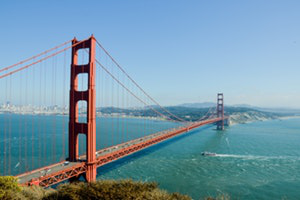

In [27]:
load_img(content_img_path)

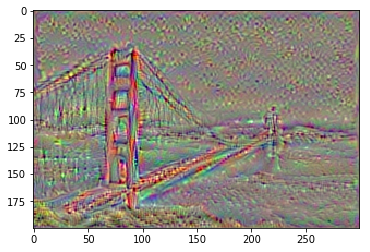

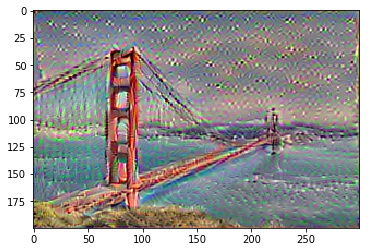

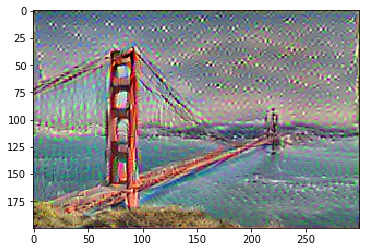

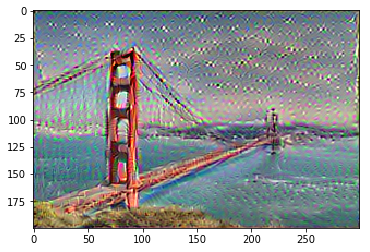

In [28]:
for image in generated_content_images:
    plt.figure()
    plt.imshow(image)

In [29]:
style_image = preprocess_image(style_img_path, height=height, width=width)

In [30]:
style_loss_layers_outputs = [layer.get_output_at(1) for name,layer in layers.items() if name.endswith('conv1')]

In [31]:
style_model = Model(inputs=model.inputs, outputs=style_loss_layers_outputs)

In [32]:
style_features = [K.variable(feature) for feature in style_model.predict(style_image)]

In [33]:
style_loss_weights = [0.2] * 5

In [34]:
style_loss = 0
for S, G, w in zip(style_features, style_model.output, style_loss_weights):
    style_loss += w * get_style_loss(S, G)

In [35]:
style_gradients = K.gradients(style_loss, style_model.input)

In [36]:
style_loss_and_gradient = K.function(inputs=[style_model.input], outputs=[style_loss] + style_gradients)

In [37]:
def style_io_format_handler(img_1d):
    img_3d = img_1d.reshape(1, height, width, 3)
    style_loss, gradient = style_loss_and_gradient(inputs=[img_3d])
    return style_loss, gradient.flatten().astype('float64')

In [38]:
x = np.random.normal(size=(1*height*width*3))

In [39]:
generated_style_images = minimize(style_io_format_handler, x)

iteration: 1, loss: 20954550.0
iteration: 2, loss: 1210530.5
iteration: 3, loss: 384865.0
iteration: 4, loss: 229513.0
iteration: 5, loss: 171966.59375
iteration: 6, loss: 138646.703125
iteration: 7, loss: 117978.5703125
iteration: 8, loss: 99610.1484375
iteration: 9, loss: 87768.9609375
iteration: 10, loss: 78039.7265625
iteration: 11, loss: 69859.390625
iteration: 12, loss: 63696.15234375
iteration: 13, loss: 58278.36328125
iteration: 14, loss: 52821.99609375
iteration: 15, loss: 48356.55078125
iteration: 16, loss: 44751.39453125
iteration: 17, loss: 41731.27734375
iteration: 18, loss: 38199.42578125
iteration: 19, loss: 35372.26171875
iteration: 20, loss: 33226.6171875


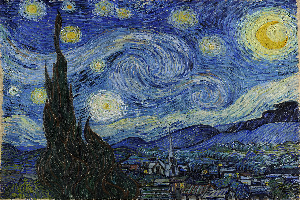

In [40]:
load_img(style_img_path, target_size=(height, width))

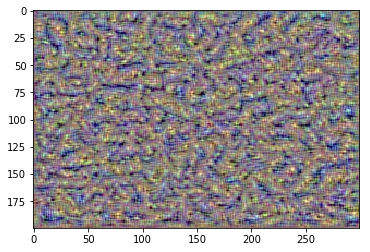

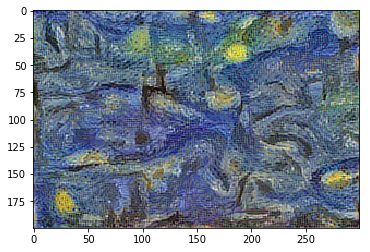

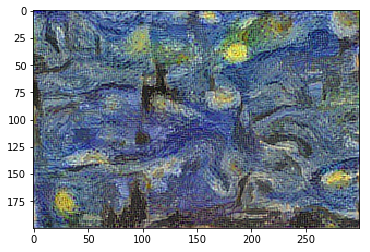

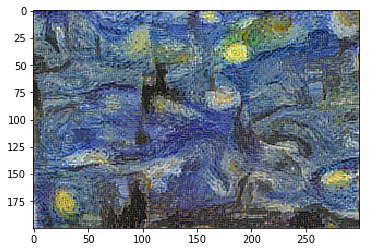

In [41]:
for image in generated_style_images:
    plt.figure()
    plt.imshow(image)

In [42]:
alpha = 0.001
beta = 1.0

In [43]:
loss = alpha * content_loss + beta * style_loss

In [44]:
gradients = K.gradients(loss, model.input)

In [45]:
loss_and_gradient = K.function(inputs=[model.input], outputs=[loss] + gradients)

In [46]:
def io_format_handler(img_1d):
    img_3d = img_1d.reshape(1, height, width, 3)
    l, g = loss_and_gradient(inputs=[img_3d])
    return l, g.flatten().astype('float64')

In [50]:
x = np.random.normal(size=(1*height*width*3))

In [51]:
generated_images = minimize(io_format_handler, x)

iteration: 1, loss: 9931860.0
iteration: 2, loss: 2405900.5
iteration: 3, loss: 1721040.25
iteration: 4, loss: 1496670.25
iteration: 5, loss: 1387489.875
iteration: 6, loss: 1305635.0
iteration: 7, loss: 1251969.875
iteration: 8, loss: 1216402.0
iteration: 9, loss: 1188148.625
iteration: 10, loss: 1166078.75
iteration: 11, loss: 1147885.375
iteration: 12, loss: 1132696.625
iteration: 13, loss: 1120156.375
iteration: 14, loss: 1106745.0
iteration: 15, loss: 1096152.25
iteration: 16, loss: 1085705.0
iteration: 17, loss: 1077540.0
iteration: 18, loss: 1069129.0
iteration: 19, loss: 1061976.5
iteration: 20, loss: 1055779.625


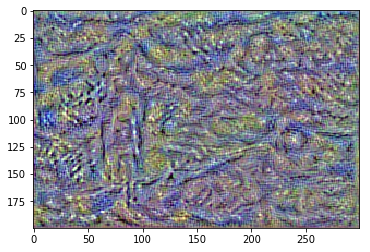

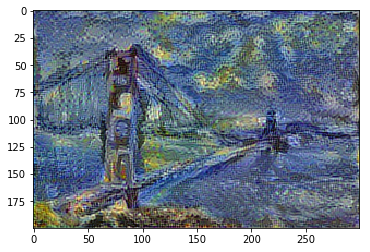

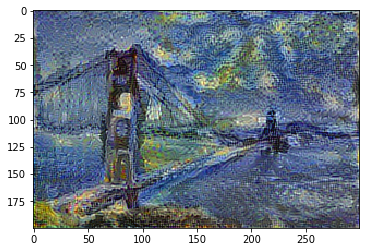

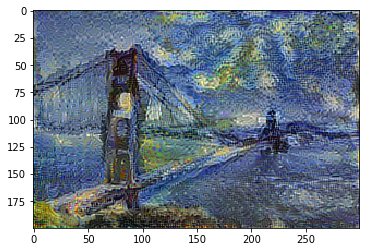

In [52]:
for image in generated_style_images:
    plt.figure()
    plt.imshow(image)